# Data Extraction
**BirdLife KBA Change Detection**

Author: Michael Dear, April 2024

## Usage
This notebook should be run from within the [Digital Earth Australia Sandbox](https://app.sandbox.dea.ga.gov.au/).

## Setup

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray
import numpy as np
import pandas as pd
import geopandas as gpd

from datacube.drivers.netcdf import write_dataset_to_netcdf

import sys
sys.path.insert(1, '../../Tools/')

from dea_tools.plotting import rgb, display_map
from dea_tools.datahandling import load_ard
from dea_tools.dask import create_local_dask_cluster
from dea_tools.bandindices import calculate_indices

# For masking using a polygon
from shapely.geometry import mapping

# Turn off warnings
import warnings
warnings.filterwarnings('ignore')

### Global Parameters
* Global parameters are used in multiple places
* Local parameters should be found above the relevant code

Description
* kba_name: This has to match the name in the KBA_polygon dataset. See KBA_names.csv for a list of names.
* kba_abbrev: Abbreviation for the KBA. This will be added to file output rather than the full KBA name.

In [2]:
data_dir = 'data/'

kba_name = 'Greater Blue Mountains' 
kba_abbrev = 'GBM'
current_year = 2024 # The dataset will include this year plus the 5 previous years

spatial_res = 100 # Spatial resolution of the raster dataset in metres
crs = 3577

## Create Dask Client

In [3]:
# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/mjdear68@gmail.com/proxy/8787/status,
Dashboard: /user/mjdear68@gmail.com/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41247,Workers: 1
Dashboard: /user/mjdear68@gmail.com/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:41487,Total threads: 2
Dashboard: /user/mjdear68@gmail.com/proxy/38589/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:37389,


### Connect to the datacube
The next step is to connect to the datacube database.
The resulting `dc` datacube object can then be used to load data.
The `app` parameter is a unique name used to identify the notebook that does not have any effect on the analysis.

In [4]:
dc = datacube.Datacube(app="KBA")

## Step 1: Choose a study area
Use *one* of the methods below to set the bounding box for the study area.

### Bounding box from polygon

In [6]:
# Load the polygon
poly = gpd.read_file('../../data/vector/BirdLife_KBA_Australia_2022.sqlite').query('name==@kba_name')

In [7]:
poly

,name,description,timestamp,begin,end,altitudemode,tessellate,extrude,visibility,draworder,icon,snippet,geometry
309,Greater Blue Mountains,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",NaT,NaT,NaT,clampToGround,-1,0,-1,NaN,NaN,,"MULTIPOLYGON Z (((150.20739 -34.29354 0.00000,..."


In [8]:
# Set the CRS to EPSG:4326
poly = poly.set_crs(4326)

<Axes: >

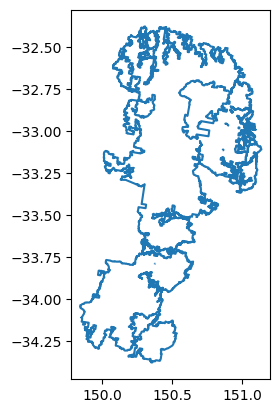

In [9]:
# Plot to check
poly.boundary.plot()

In [10]:
# Get the coordinates of the bounding box
bounds = poly.total_bounds
bounds

array([149.84385905, -34.37803982, 151.1352157 , -32.37708758])

In [11]:
# Set the latitude and longitude
study_area_lat = (bounds[1], bounds[3])
study_area_lon = (bounds[0], bounds[2])

In [12]:
display_map(x=study_area_lon, y=study_area_lat)

## Step 2: Load data from the DEA's Open Data Cube (ODC)
*Note: Cloud Masks* The `s2cloudless` mask for Sentinel might classify sand as cloud. If this occurs, try using the `'cloud_mask':'fmask'` in the `query`.

### Create a predicate function to filter for the given months

1 = Jan, 2 = Feb etc

See https://opendatacube.slack.com/archives/C0L4WHVME/p1712644345349049?thread_ts=1712641322.218539&cid=C0L4WHVME

In [13]:
def filter_months(dataset):
    return dataset.time.begin.month in [1,2,3]

### Create a Dask chunk size array
This will adjust automatically depending on the bounding box of the study area.

See https://gis.stackexchange.com/questions/142326/calculating-longitude-length-in-miles for converting longitude to metres.

In [14]:
# Approximate pixel dimensions of the study area in the desired spatial resolution.
# Used for setting the dask chunk dimensions.
dask_chunk_size = []
dask_chunk_prop = 0.5 # Use this to set the proportion of the x, y dimensions to set as Dask chunk sizes

# x length
dask_chunk_size.append(
    (np.abs((study_area_lon[1] - study_area_lon[0])*111111
         *np.cos(study_area_lat[0]/(2*np.pi))
         /spatial_res
         *dask_chunk_prop)
         .round()
))

# y length
dask_chunk_size.append(
    (np.abs((study_area_lat[1] - study_area_lat[0])*111111
         /spatial_res
         *dask_chunk_prop)
         .round()
)
)

# Dask will not accept numpy integers. Need to convert to regular integers.
dask_chunk_size = [int(i) for i in dask_chunk_size]
for i in dask_chunk_size:
    print(type(i))

<class 'int'>
<class 'int'>


In [16]:
# Query
query = {
  'products':["ga_s2am_ard_3", "ga_s2bm_ard_3"],
  'measurements' : ["nbart_red", "nbart_blue", "nbart_green", "nbart_nir_1"],
  'x':study_area_lon,
  'y':study_area_lat,
  'output_crs':'EPSG:3577', # 3308 NSW Lambert; 3577 Australian Albers; 4326 does not work - not sure why
  'resolution':(-spatial_res, spatial_res),
  'group_by':'solar_day',
  'dask_chunks':{"time": 1, "x": dask_chunk_size[0] , "y": dask_chunk_size[1]},
  'cloud_mask':'s2cloudless', # Uncomment if using Sentinel data; Note: s2cloudless might mask sand
  # 'cloud_mask':'fmask', # Use fmask if s2cloudless is masking sand
  'dataset_predicate': filter_months,
  'min_gooddata':0.90 # This will slow down dataset search
}

In [17]:
%%time
ds_dask = load_ard(dc=dc, time=(str(current_year-5), str(current_year)), **query) 

Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using s2cloudless


/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Filtering to 15 out of 213 time steps with at least 90.0% good quality pixels
Applying s2cloudless pixel quality/cloud mask
Returning 15 time steps as a dask array
CPU times: user 35.4 s, sys: 1.68 s, total: 37.1 s
Wall time: 4min 9s


In [18]:
ds_dask

<xarray.Dataset>
Dimensions:      (time: 15, y: 2383, x: 1504)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-15T00:05:35.174000 ... 2024-01...
  * y            (y) float64 -3.646e+06 -3.646e+06 ... -3.884e+06 -3.884e+06
  * x            (x) float64 1.629e+06 1.629e+06 ... 1.779e+06 1.779e+06
    spatial_ref  int32 3577
Data variables:
    nbart_red    (time, y, x) float32 dask.array<chunksize=(1, 1112, 494), meta=np.ndarray>
    nbart_blue   (time, y, x) float32 dask.array<chunksize=(1, 1112, 494), meta=np.ndarray>
    nbart_green  (time, y, x) float32 dask.array<chunksize=(1, 1112, 494), meta=np.ndarray>
    nbart_nir_1  (time, y, x) float32 dask.array<chunksize=(1, 1112, 494), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Check dates in the target range
It is worth doing a manual review using the [Digital Earth Australia Map](https://maps.dea.ga.gov.au/#share=s-02TACjEp7EBe0FBXTOYPXvGts7f) to check for thin cloud contamination. 

In [19]:
ds_dask.time

<xarray.DataArray 'time' (time: 15)>
array(['2019-01-15T00:05:35.174000000', '2019-01-25T00:05:35.970000000',
       '2019-03-26T00:05:38.311180000', '2020-01-10T00:05:33.683034000',
       '2020-02-19T00:05:33.335368000', '2020-03-20T00:05:35.594541000',
       '2021-01-14T00:05:40.111623000', '2021-01-24T00:05:39.905503000',
       '2022-02-18T00:05:40.435515000', '2022-03-20T00:05:42.768756000',
       '2023-01-09T00:05:36.160386000', '2023-02-03T00:05:38.004323000',
       '2023-02-18T00:05:37.679113000', '2023-03-05T00:05:36.094006000',
       '2024-01-19T00:05:30.279537000'], dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 2019-01-15T00:05:35.174000 ... 2024-01...
    spatial_ref  int32 3577
Attributes:
    units:    seconds since 1970-01-01 00:00:00

## Dataset Options
Choose either Option 1 or Option 2. Trying both could be worthwhile, depending on the study area.

### Option 1
Use this option if cloud-free observations are available during the annual time window.
* Using the list of dates above as a guide, choose one cloud-free observation manually for each year using the [DEA Map](https://maps.dea.ga.gov.au/#share=s-02TACjEp7EBe0FBXTOYPXvGts7f)
* Drop the other observations
* Create the NDVI variable

In [23]:
# These are the dates that will be kept
dates = ['2019-01-15', '2020-03-20', '2021-01-24', '2022-02-18', '2023-01-09', '2024-01-19']

In [24]:
ds_dask_ready = xr.concat([ds_dask.sel(time=date) for date in dates], dim='time')

In [25]:
# Add an NDVI variable
ds_dask_ready = calculate_indices(ds_dask_ready, index='NDVI', collection='ga_s2_3')
ds_dask_ready

<xarray.Dataset>
Dimensions:      (time: 6, y: 2383, x: 1504)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-15T00:05:35.174000 ... 2024-01...
  * y            (y) float64 -3.646e+06 -3.646e+06 ... -3.884e+06 -3.884e+06
  * x            (x) float64 1.629e+06 1.629e+06 ... 1.779e+06 1.779e+06
    spatial_ref  int32 3577
Data variables:
    nbart_red    (time, y, x) float32 dask.array<chunksize=(1, 1112, 494), meta=np.ndarray>
    nbart_blue   (time, y, x) float32 dask.array<chunksize=(1, 1112, 494), meta=np.ndarray>
    nbart_green  (time, y, x) float32 dask.array<chunksize=(1, 1112, 494), meta=np.ndarray>
    nbart_nir_1  (time, y, x) float32 dask.array<chunksize=(1, 1112, 494), meta=np.ndarray>
    NDVI         (time, y, x) float32 dask.array<chunksize=(1, 1112, 494), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Option 2
Resampling along the time dimension can be useful for creating cloud-free composites and for reducing the size of the dataset. It is also possible to resample along the spatial dimensions, although it is probably easier to do this by changing the `resolution` in the `load_ard` function.

#### Thin Cloud
Thin cloud may not be detected by cloud masking algorithms. If thin cloud is present, resampling using `.min()` for RGB and NIR are good choices. This helps correct the higher reflectance values in the RGB and NIR bands caused by thin cloud. If thin cloud is not an issue, `.mean()` or `.median()` would be preferred. For 'NDVI', `.max()` is usually the best option.

#### Method
* Resample RGB, NIR to years using minimum
* Create NDVI for each year

In [42]:
# Resample 
ds_dask_ready = (ds_dask[['nbart_red', 'nbart_green', 'nbart_blue', 'nbart_nir_1']]
             .resample(time='Y')
             .min()
            )

In [43]:
# Add an NDVI variable
ds_dask_ready = calculate_indices(ds_dask_ready, index='NDVI', collection='ga_s2_3')
ds_dask_ready

<xarray.Dataset>
Dimensions:      (time: 6, y: 411, x: 477)
Coordinates:
  * y            (y) float64 -3.762e+06 -3.762e+06 ... -3.803e+06 -3.803e+06
  * x            (x) float64 2.762e+05 2.762e+05 ... 3.236e+05 3.238e+05
    spatial_ref  int32 3577
  * time         (time) datetime64[ns] 2019-12-31 2020-12-31 ... 2024-12-31
Data variables:
    nbart_red    (time, y, x) float32 dask.array<chunksize=(1, 199, 208), meta=np.ndarray>
    nbart_green  (time, y, x) float32 dask.array<chunksize=(1, 199, 208), meta=np.ndarray>
    nbart_blue   (time, y, x) float32 dask.array<chunksize=(1, 199, 208), meta=np.ndarray>
    nbart_nir_1  (time, y, x) float32 dask.array<chunksize=(1, 199, 208), meta=np.ndarray>
    NDVI         (time, y, x) float32 dask.array<chunksize=(1, 199, 208), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

## Complete the next steps for both options

### Make a 'year' dimension

In [26]:
ds_dask_ready = (ds_dask_ready.assign_coords({'year':ds_dask_ready.time.dt.year.astype('int16')})
 .swap_dims({'time':'year'})
 .drop_vars('time')
)
ds_dask_ready

<xarray.Dataset>
Dimensions:      (year: 6, y: 2383, x: 1504)
Coordinates:
  * y            (y) float64 -3.646e+06 -3.646e+06 ... -3.884e+06 -3.884e+06
  * x            (x) float64 1.629e+06 1.629e+06 ... 1.779e+06 1.779e+06
    spatial_ref  int32 3577
  * year         (year) int16 2019 2020 2021 2022 2023 2024
Data variables:
    nbart_red    (year, y, x) float32 dask.array<chunksize=(1, 1112, 494), meta=np.ndarray>
    nbart_blue   (year, y, x) float32 dask.array<chunksize=(1, 1112, 494), meta=np.ndarray>
    nbart_green  (year, y, x) float32 dask.array<chunksize=(1, 1112, 494), meta=np.ndarray>
    nbart_nir_1  (year, y, x) float32 dask.array<chunksize=(1, 1112, 494), meta=np.ndarray>
    NDVI         (year, y, x) float32 dask.array<chunksize=(1, 1112, 494), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [27]:
# Remove units from year dimension - causes problems when loading saved dataset otherwise.
print(ds_dask_ready.year.attrs)
del ds_dask_ready.year.attrs['units']
print(ds_dask_ready.year.attrs)

{'units': 'seconds since 1970-01-01 00:00:00'}
{}


### Dataset details

In [28]:
print('Dataset size = ', np.round(ds_dask_ready.nbytes/1024**3,3), 'Gb')

Dataset size =  0.401 Gb


In [29]:
ds_dask_ready.NDVI.data

dask.array<truediv, shape=(6, 2383, 1504), dtype=float32, chunksize=(1, 1112, 494), chunktype=numpy.ndarray>

### Load the dataset into memory
Loading the data can take a long time depending on the size of the study area and the duration of the study. Clicking the Dashboard link in the output from loading Dask at the beginning of the notebook will open a page showing the progress of the task.

Here are some ways to decrease the load time:
* Optimize the chunk size. This means experimenting with increasing or decreasing the number of `x` and `y` pixels in the `dask_chunks` parameter of the `load_ard` function. 1024 and 2048 are good places to start, but it depends on the size of your x and y dimensions. Leave `"time" : 1`.
* Reduce the spatial resolution in the `load_ard` function.
* Reduce the number of `products` in the `load_ard` function e.g. choose Sentinel 2A or Sentinel 2B  rather than both.
* Reduce the period in the `load_ard` function by changing the `time` parameter.
* Try a different time of day e.g. after work hours. 

In [30]:
%%time
ds = ds_dask_ready.load()

CPU times: user 7.85 s, sys: 885 ms, total: 8.74 s
Wall time: 1min 7s


### Plot a time step to check the data 

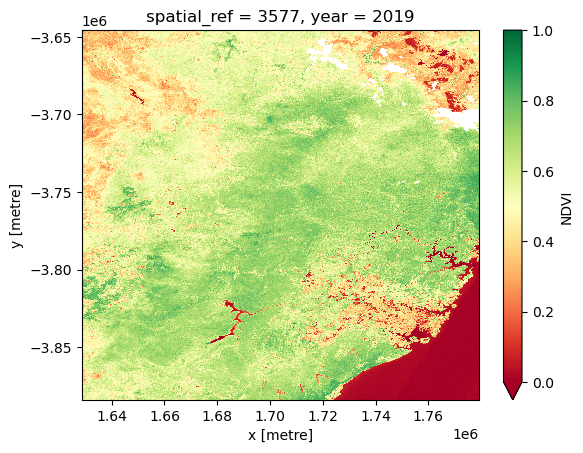

In [31]:
ds.isel(year=0).NDVI.plot(vmin=0, vmax=1, cmap='RdYlGn')

### Close the Dask client if it is no longer required

In [27]:
client.close()

### Create a mask

In [32]:
# Copy the first variable in the dataset to use as the basis for the mask
mask = ds[list(ds.data_vars.keys())[0]].isel(year=0)
mask.name = 'mask'

# Make sure the mask and polygon have the same crs
poly = poly.to_crs(crs)
mask = mask.rio.write_crs(crs)

# Clip the mask using the polygon
mask = mask.rio.clip(poly.geometry.apply(mapping), poly.crs, drop=False)

# Set all masked values to nan and all non-masked values to 1
mask = mask.where(mask != -999, np.nan)
mask = mask.where(mask.isnull(), 1)

mask

<xarray.DataArray 'mask' (y: 2383, x: 1504)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * y            (y) float64 -3.646e+06 -3.646e+06 ... -3.884e+06 -3.884e+06
  * x            (x) float64 1.629e+06 1.629e+06 ... 1.779e+06 1.779e+06
    year         int16 2019
    spatial_ref  int64 0
Attributes:
    units:         1
    grid_mapping:  spatial_ref
    _FillValue:    -999.0

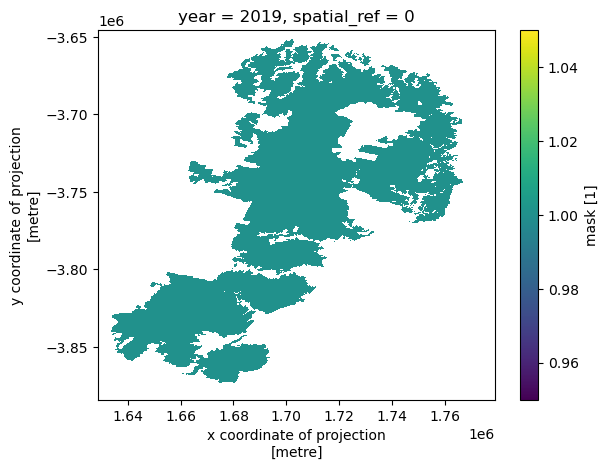

In [33]:
# Test plot
mask.plot()

## Step 3: NDVI Classification

The following NDVI thresholds were used to develop the classification. 
|Class Number|Class Name|Threshold|
|:-:|:-|:-:|
|1|Water|$$\text{NDVI} \lt 0$$|
|2|Bare ground|$$0 \le \text{NDVI} \lt 0.15$$|
|3|Sparse vegetation|$$0.15 \le \text{NDVI} \lt 0.5$$|
|4|Medium-density vegetation|$$0.5 \le \text{NDVI} \lt 0.8$$|
|5|Dense vegetation|$$\text{NDVI} \ge 0.8$$|
|6|No data|nan|

The thresholds were derived from manual review of the study area using [QGIS](www.qgis.org) the following sources:

* [Map Information - Normalised Difference Vegetation Index: Australian Bureau of Meterology](http://www.bom.gov.au/climate/austmaps/about-ndvi-maps.shtml)
* [NDVI, the Foundation for Remote Sensing Phenology : USGS](https://www.usgs.gov/special-topics/remote-sensing-phenology/science/ndvi-foundation-remote-sensing-phenology)

### Create the classification dataset
<a id='create_classification'></a>

In [34]:
# Function to make threshold classification variable
# See https://earthpy.readthedocs.io/en/latest/gallery_vignettes/plot_calculate_classify_ndvi.html for np.digitize
# See https://docs.xarray.dev/en/latest/generated/xarray.Dataset.assign.html for assigning numpy array to a dataset
def make_class_var(ds, class_bins, var, newvar):
    ds = ds.assign({newvar: (ds.dims, (np.digitize(ds[var], class_bins).astype(np.int16)))}) 
    # ds[newvar] = ds[newvar].where(ds[newvar]<ds[newvar].max()).astype(np.int16) # Set the nan class to nan
    return ds

In [35]:
NDVI_class_bins = [-np.inf, 0, 0.15, 0.5, 0.8, np.inf]

In [36]:
ds = make_class_var(ds, class_bins = NDVI_class_bins, var='NDVI', newvar='NDVI_Class')
ds

<xarray.Dataset>
Dimensions:      (year: 6, y: 2383, x: 1504)
Coordinates:
  * y            (y) float64 -3.646e+06 -3.646e+06 ... -3.884e+06 -3.884e+06
  * x            (x) float64 1.629e+06 1.629e+06 ... 1.779e+06 1.779e+06
    spatial_ref  int32 3577
  * year         (year) int16 2019 2020 2021 2022 2023 2024
Data variables:
    nbart_red    (year, y, x) float32 973.0 963.0 1.011e+03 ... 445.0 441.0
    nbart_blue   (year, y, x) float32 598.0 581.0 597.0 ... 581.0 545.0 575.0
    nbart_green  (year, y, x) float32 835.0 823.0 850.0 ... 487.0 473.0 483.0
    nbart_nir_1  (year, y, x) float32 2.54e+03 2.571e+03 ... 460.0 485.0
    NDVI         (year, y, x) float32 0.4461 0.455 0.4475 ... 0.01657 0.04752
    NDVI_Class   (year, y, x) int16 3 3 3 3 3 3 3 3 3 3 ... 2 2 2 2 2 2 2 2 2 2
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [37]:
# Check all classes present
np.unique(ds.NDVI_Class)

array([1, 2, 3, 4, 5, 6], dtype=int16)

### Plot a time step to check the data 

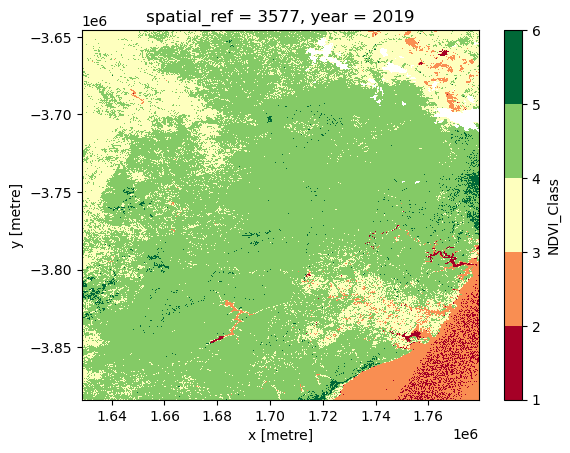

In [38]:
ds.NDVI_Class.isel(year=0).plot(levels=[1,2,3,4,5,6], cmap='RdYlGn')

## Step 4: 5-year Summary Dataset
These are 5-year (five years prior to the current year) mean data for RGB and NDVI. A 5-year NDVI_Class is obtained from the 5-year NDVI mean. This provides a baseline to compare the current year against.

In [39]:
ds_5yr = (ds[['nbart_red','nbart_green','nbart_blue','NDVI']]
          .sel(year=slice(2019,2023))
          .mean(dim='year')
         )
ds_5yr

<xarray.Dataset>
Dimensions:      (y: 2383, x: 1504)
Coordinates:
  * y            (y) float64 -3.646e+06 -3.646e+06 ... -3.884e+06 -3.884e+06
  * x            (x) float64 1.629e+06 1.629e+06 ... 1.779e+06 1.779e+06
    spatial_ref  int32 3577
Data variables:
    nbart_red    (y, x) float32 837.4 867.2 902.0 ... 426.0 404.6 425.0
    nbart_green  (y, x) float32 779.8 800.0 819.0 999.0 ... 477.2 455.2 473.6
    nbart_blue   (y, x) float32 508.4 526.5 537.0 657.0 ... 569.0 547.6 564.6
    NDVI         (y, x) float32 0.5288 0.5346 0.535 ... -0.004833 -0.002225

### Plot a variable to check the data

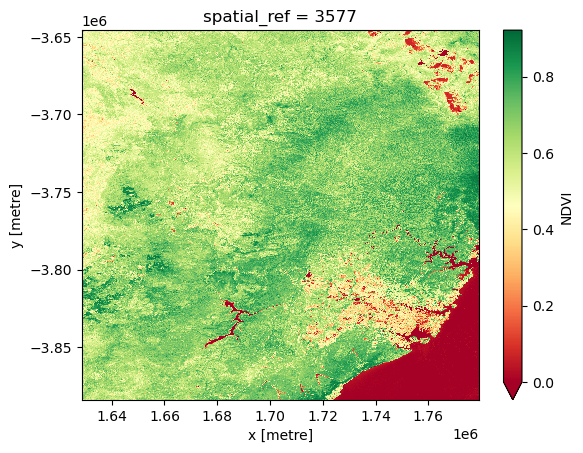

In [40]:
ds_5yr.NDVI.plot(cmap='RdYlGn', vmin=0)

### Create the NDVI_Class variable
This reuses the classification <a href='#create_classification'>defined earlier</a>.

In [41]:
ds_5yr = make_class_var(ds_5yr, class_bins = NDVI_class_bins, var='NDVI', newvar='NDVI_Class')
ds_5yr

<xarray.Dataset>
Dimensions:      (y: 2383, x: 1504)
Coordinates:
  * y            (y) float64 -3.646e+06 -3.646e+06 ... -3.884e+06 -3.884e+06
  * x            (x) float64 1.629e+06 1.629e+06 ... 1.779e+06 1.779e+06
    spatial_ref  int32 3577
Data variables:
    nbart_red    (y, x) float32 837.4 867.2 902.0 ... 426.0 404.6 425.0
    nbart_green  (y, x) float32 779.8 800.0 819.0 999.0 ... 477.2 455.2 473.6
    nbart_blue   (y, x) float32 508.4 526.5 537.0 657.0 ... 569.0 547.6 564.6
    NDVI         (y, x) float32 0.5288 0.5346 0.535 ... -0.004833 -0.002225
    NDVI_Class   (y, x) int16 4 4 4 3 3 3 3 3 3 3 3 4 ... 2 1 1 1 1 2 1 1 1 1 1

### Plot to check the classification

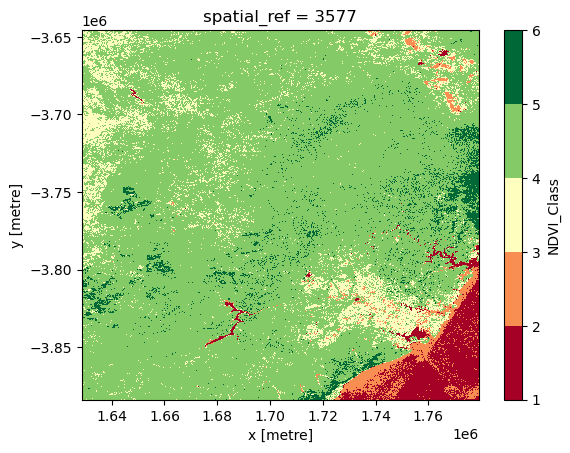

In [42]:
ds_5yr.NDVI_Class.plot(levels=[1,2,3,4,5,6], cmap='RdYlGn')

## Step 5: Export data

### netCDF
This format is suitable for further analysis using Python or other coding languages.

In [44]:
# Save base dataset
ds.to_netcdf(data_dir+'netcdf/'+kba_abbrev+'_KBA_'+str(current_year-5)+'-'+str(current_year)+'.nc')

In [45]:
# Save 5-year mean dataset
ds_5yr.to_netcdf(data_dir+'netcdf/'+kba_abbrev+'_KBA_'+str(current_year-5)+'-'+str(current_year)+'_5-year.nc')

In [46]:
# Save mask data array
mask.to_netcdf(data_dir+'netcdf/'+kba_abbrev+'_KBA_'+'mask.nc')

### GeoTIFF
These exports are useful for further analysis using a graphical GIS systems such as QGIS. Using the <a href='#plots'>plots</a> for visual assessment should be sufficient in most cases.

#### Individual variables
Each variable is saved as a time series in a geoTIFF file.

In [42]:
for key, value in ds.data_vars.items():
    ds[key].rio.to_raster(data_dir+'geoTIFF/'+kba_abbrev+'_KBA_'+key+'.tiff')

#### Time steps

Each year is saved with all variables in a geoTIFF file.

**Note**: Converting `to_array()` is essential to avoid "ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''" error.  


In [43]:
# Need to remove 'grid_mapping' from attributes or export to geoTIFF will fail.
print(ds.attrs)
del ds.attrs['grid_mapping']
print(ds.attrs)

{'crs': 'EPSG:3577', 'grid_mapping': 'spatial_ref'}
{'crs': 'EPSG:3577'}


In [44]:
for yr in ds.year.values:
     (ds
     .sel(year=yr)
     .to_array() # Essential!
     .rio.to_raster(data_dir+'geoTIFF/'+kba_abbrev+'_KBA_'+str(yr)+'.tiff')
     )

#### 5-year dataset

In [45]:
ds_5yr.rio.to_raster(data_dir+'geoTIFF/'+kba_abbrev+'_KBA_5-year_mean.tiff')